---
---
# NEURAL NETWORKS AND DEEP LEARNING

### A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli

# Homework 1 - Supervised Deep Learning
---
---

## Classification task

* The goal is to train a neural network that maps an input image (from fashionMNIST) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

### Dataset

In [19]:
#################
#### IMPORTS ####
#################

# Arrays
import numpy as np

# Deep Learning stuff
import torch
import torchvision

# Images display and plots
import matplotlib.pyplot as plt

# Other
import os


In [ ]:
# Setting the values of the seeds for reproducibility
torch.manual_seed(2012264)    
np.random.seed(2012264)


In [25]:
# If we have already the datafolder, do not download.
if(os.path.isdir('./classifier_data/FashionMNIST')):
    train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=False)
    test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=False)
else:
    train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
    test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)
    

In [27]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")


Training device: cpu


In [17]:
def plot_mnistimg(dataset, sample, output = False, size = 3):
    '''
    Display the sample-th image from dataset (can be trainingset or testset) and its true
    label.
    Eventually display the predicted label in output.
    Size of the image can be changed changing size input parameter
    '''
    
    description = ['T-shirt/top','Trouser','Pullover',
                   'Dress','Coat','Sandal','Shirt',
                   'Sneaker','Bag','Ankle boot']
    
    image = dataset[sample][0]
    label = dataset[sample][1]

    fig = plt.figure(figsize=(size,size))
    plt.imshow(image, cmap='Greys')
    
    print(f"Sample: {sample_index}")
    print(f"True Label: {description[label]}")
    
    if output:
        print(f"Prediction: {description[output]}")
    
    plt.axis("off")
    plt.show()
    

Sample: 0
True Label: T-shirt/top


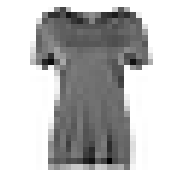

In [26]:
plot_mnistimg(train_dataset, 10)